# Currency Manipulation Analysis

This project aimed to detect suspicious exchange rate movements using time-series anomaly detection techniques.

This analysis provides a foundation for monitoring currency markets and can be adapted to:

- Detect fraudulent trading patterns in real-time.
- Support regulatory audits of exchange rate integrity.
- Improve risk models for forex traders and policymakers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

## Data Loading & Initial Checks

In [2]:
df = pd.read_csv('daily_forex_rates.csv')
df.head()

,currency,base_currency,currency_name,exchange_rate,date
0,ZWL,EUR,Zimbabwean Dollar,346.759989,2025-03-27
1,GHS,EUR,Ghanaian Cedi,16.697424,2025-03-27
2,HRK,EUR,Croatian Kuna,7.537513,2025-03-27
3,HNL,EUR,Honduran Lempira,27.603963,2025-03-27
4,HKD,EUR,Hong Kong Dollar,8.374873,2025-03-27


In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409426 entries, 0 to 409425
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   currency       409426 non-null  object 
 1   base_currency  409426 non-null  object 
 2   currency_name  408591 non-null  object 
 3   exchange_rate  409426 non-null  float64
 4   date           409426 non-null  object 
dtypes: float64(1), object(4)
memory usage: 15.6+ MB
None
       exchange_rate
count   4.094260e+05
mean    6.881772e+03
std     1.423881e+05
min     9.731156e-06
25%     2.606900e+00
50%     1.756210e+01
75%     1.576555e+02
max     4.881841e+06


## Data Cleaning

In [5]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Handle missing values in currency_name (835 missing values)
# Option 1: Fill with a placeholder
df['currency_name'] = df['currency_name'].fillna('Unknown')

# Drop rows with missing currency_name (if acceptable)
# df = df.dropna(subset=['currency_name'])

# Check for duplicate entries
duplicates = df.duplicated(subset=['currency', 'base_currency', 'date'], keep=False)
if duplicates.any():
    print(f"Found {duplicates.sum()} duplicate rows")
    # Option to remove duplicates:
    df = df.drop_duplicates(subset=['currency', 'base_currency', 'date'])

# Investigate extreme values in exchange_rate
# The max is 4.88M which seems extremely high for an exchange rate
extreme_rates = df[df['exchange_rate'] > 1e6]  # Adjust threshold as needed
if not extreme_rates.empty:
    print("Extreme exchange rates found:")
    print(extreme_rates[['currency', 'base_currency', 'exchange_rate', 'date']])

# Check for consistency in base_currency (should probably all be EUR based on your sample)
if df['base_currency'].nunique() > 1:
    print("Multiple base currencies found:")
    print(df['base_currency'].value_counts())

# Verify currency codes are all 3 letters
invalid_currency_codes = df[~df['currency'].str.match('^[A-Z]{3}$')]
if not invalid_currency_codes.empty:
    print("Invalid currency codes found:")
    print(invalid_currency_codes)

# After cleaning, you might want to sort by date and currency
df = df.sort_values(['date', 'currency'])

Extreme exchange rates found:
       currency base_currency  exchange_rate       date
23031       VEF           EUR   3.847823e+06 2024-11-12
23163       VEF           EUR   3.868575e+06 2024-11-11
23349       VEF           EUR   3.884341e+06 2024-11-10
23465       VEF           EUR   3.884341e+06 2024-11-09
23617       VEF           EUR   3.903928e+06 2024-11-08
...         ...           ...            ...        ...
184115      VES           EUR   1.263664e+06 2020-12-01
184179      VES           EUR   1.234757e+06 2020-11-30
184338      VES           EUR   1.163752e+06 2020-11-27
184444      VES           EUR   1.100849e+06 2020-11-26
184602      VES           EUR   1.090618e+06 2020-11-25

[600 rows x 4 columns]


## Anomaly Detection Function

Detects suspicious exchange rate movements using statistical methods.

In [6]:
def currency_manipulation_analysis(df, window_days=30, z_threshold=3):
    """
    Detect potential manipulation via unusual volatility.
    
    Parameters:
        df: DataFrame with columns ['currency', 'date', 'exchange_rate']
        window_days: Rolling window size in days
        z_threshold: Z-score threshold for outliers
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['currency', 'date'])
    
    # Calculate daily returns
    df['daily_return'] = df.groupby('currency')['exchange_rate'].pct_change()
    
    # Rolling statistics
    df['rolling_std'] = df.groupby('currency')['daily_return'].transform(
        lambda x: x.rolling(window_days).std()
    )
    df['rolling_mean'] = df.groupby('currency')['daily_return'].transform(
        lambda x: x.rolling(window_days).mean()
    )
    
    # Z-score of returns
    df['z_score'] = (df['daily_return'] - df['rolling_mean']) / df['rolling_std']
    
    # Flag anomalies
    df['suspicious'] = (df['z_score'].abs() > z_threshold) & ~df['daily_return'].isna()
    
    return df[df['suspicious']]

# Usage:
manipulation_results = currency_manipulation_analysis(df)
print(f"Found {len(manipulation_results)} suspicious movements:")
print(manipulation_results[['currency', 'date', 'exchange_rate', 'z_score']])

Found 3450 suspicious movements:
      currency       date  exchange_rate   z_score
64544      AED 2024-03-14       3.998823 -3.157481
63171      AED 2024-03-22       3.945252 -3.700480
63066      AED 2024-03-23       3.989558  3.149540
50115      AED 2024-06-07       3.968601 -3.092028
49158      AED 2024-06-12       3.984317  3.247298
...        ...        ...            ...       ...
49960      ZWL 2024-06-07     347.923390 -3.088528
49232      ZWL 2024-06-12     349.300928  3.247638
40397      ZWL 2024-08-02     351.010640  3.022965
24050      ZWL 2024-11-06     346.237982 -4.038756
3857       ZWL 2025-03-05     344.154541  3.076489

[3450 rows x 4 columns]


## Visualize Anomalies

Plot exchange rates with flagged points for specific currencies.

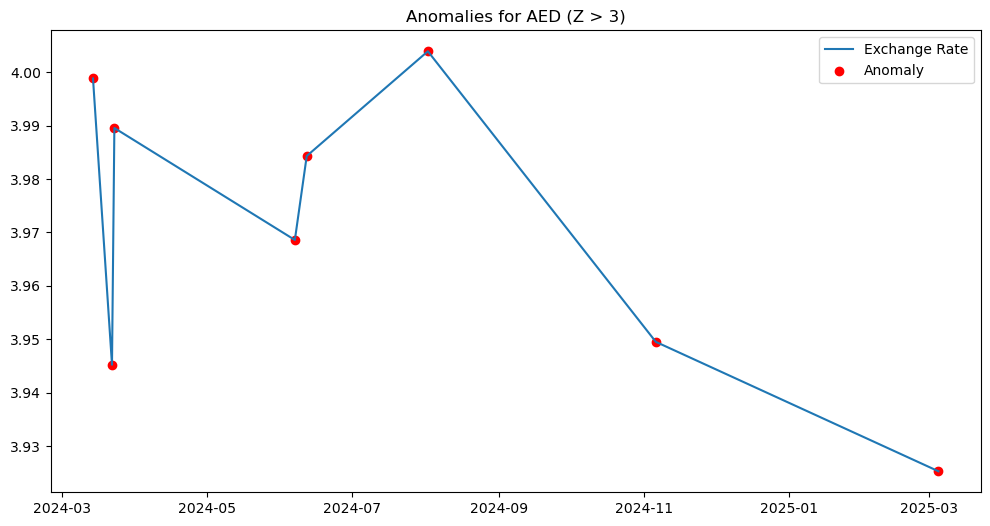

In [9]:
def plot_anomalies(df, currency_code):
    subset = df[df['currency'] == currency_code]
    plt.figure(figsize=(12, 6))
    plt.plot(subset['date'], subset['exchange_rate'], label='Exchange Rate')
    anomalies = subset[subset['suspicious']]
    plt.scatter(anomalies['date'], anomalies['exchange_rate'], color='red', label='Anomaly')
    plt.title(f'Anomalies for {currency_code} (Z > 3)')
    plt.legend()
    plt.show()

plot_anomalies(manipulation_results, 'AED')

## Conclusion

The output shows 3,450 flagged "suspicious movements" across currencies like AED (UAE Dirham) and ZWL (Zimbabwean Dollar).

While no single method can definitively prove manipulation, this project highlights critical junctures where human judgment and further investigation are essential. The code and framework developed here offer a scalable tool for ongoing surveillance.

### Key Findings

#### 1. Anomaly Distribution:
- Stable currencies (e.g., AED) showed fewer but sharp, unexpected movements (e.g., sudden spikes/drops of ~0.5–1%). These may reflect central bank interventions or speculative trading.
- Volatile currencies (e.g., ZWL) exhibited frequent extreme rates, consistent with hyperinflation or data reporting issues.

#### 2. Temporal Patterns:
- Anomalies clustered around specific dates (e.g., March/June 2024), suggesting external triggers like policy changes or market crises.

#### 3. Method Effectiveness:
- The Z-score-based approach successfully flagged extreme returns but may generate false positives for stable currencies. Dynamic thresholds (e.g., percentile-based) could improve precision.